In [1]:
import torch
import torch.nn as nn
from models.model import DBNet
import time
from data.dataset import ICDR2015Dataset
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import math
import numpy as np
from shapely import Point, Polygon
from shapely.ops import nearest_points

%load_ext autoreload
%autoreload 2

In [2]:
model = DBNet().cuda()

for _ in range(100):
    x = torch.randn((16, 3, 224, 224), device='cuda')
    _ = model(x)

In [9]:
def get_dist_to_poly(polygon, point):
    pts = nearest_points(polygon.exterior, point)
    return pts[0].distance(pts[1])

In [84]:
def get_thresholds(distances, G, Gs, Gd, D, w, h):
    border = Gd.difference(Gs)
    x1, y1, x2, y2 = border.bounds
    x1, y1, x2, y2 = math.floor(x1), math.floor(y1), math.ceil(x2), math.ceil(y2)

    for i in range(x2 - x1 + 1):
        for j in range(y2 - y1 + 1):
            x = x1 + i
            y = y1 + j
            if x > w or x < 0 or y > h or y < 0:
                continue

            point = Point(x, y)
            if border.contains(point): 
                distance = get_dist_to_poly(G, point)
                distances[x, y] = max(distances[x, y], 1 - np.clip(distance / D, 0, 1))

In [85]:
def get_polygons(point):
    G = Polygon(point[:-1].reshape(-1, 2))
    D = G.area * (1 - 0.4 ** 2) / G.length
    Gs = G.buffer(-D, join_style=2)
    Gd = G.buffer(D, join_style=2)
    return G, Gs, Gd, D

In [86]:
def get_threshold_map(points, w, h):
    threshold_map = np.zeros((w, h), dtype=np.float32)

    for point in points:
        G, Gs, Gd, D = get_polygons(point)
        get_thresholds(threshold_map, G, Gs, Gd, D, w, h)
    return threshold_map

In [87]:
def get_prob_map(polygons, w, h):
    prob_map = np.zeros((w, h), dtype=np.float32)
    
    for poly in polygons:
        _, Gs, _, D = get_polygons(poly)
        x1, y1, x2, y2 = Gs.bounds
        x1, y1, x2, y2 = math.floor(x1), math.floor(y1), math.ceil(x2), math.ceil(y2)

        for i in range(x2 - x1 + 1):
            for j in range(y2 - y1 + 1):
                x = x1 + i
                y = y1 + j
                if x > w or x < 0 or y > h or y < 0:
                    continue

                point = Point(x, y)
                if Gs.contains(point): 
                    prob_map[x, y] = 1
    return prob_map

In [88]:
dset = ICDR2015Dataset('data/icdr2015')

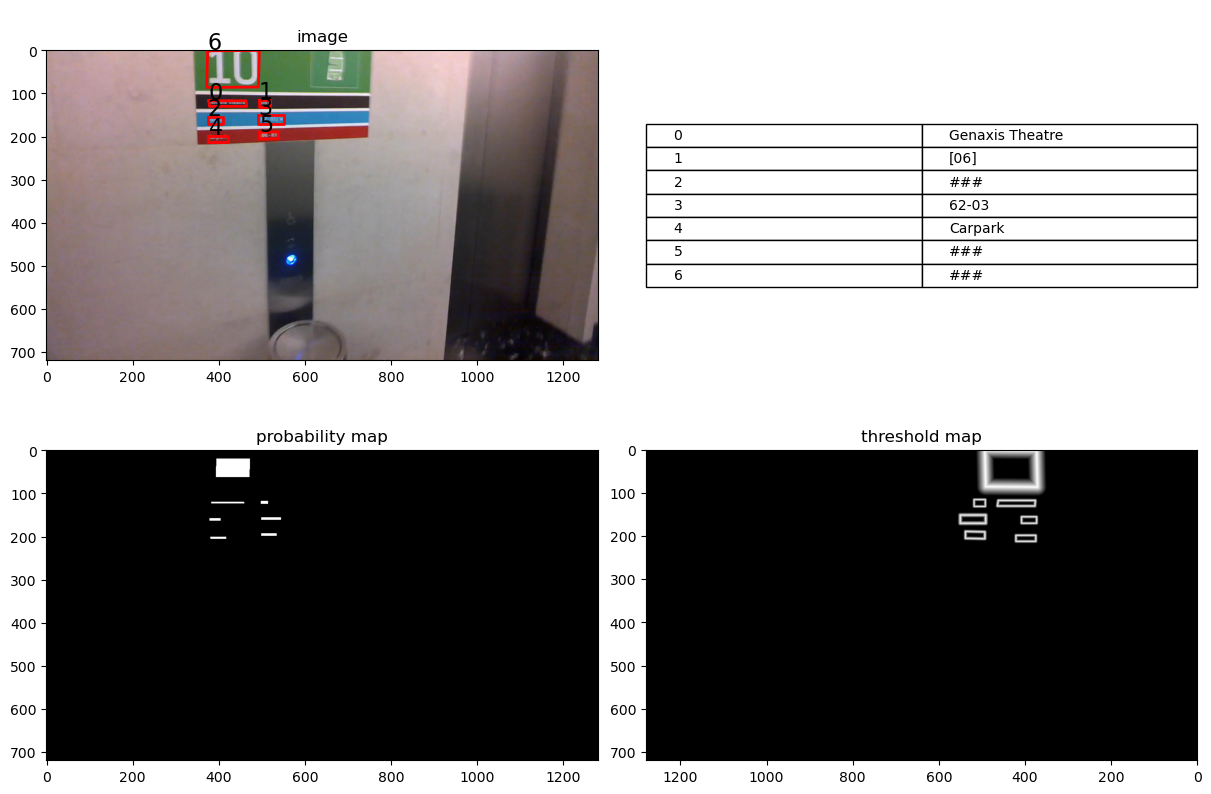

In [198]:
img, points = dset[0]

w, h = img.size
prob_map = get_prob_map(points, w, h)
threshold_map = get_threshold_map(points, w, h)


fig = plt.figure(layout='constrained', figsize=(12, 8))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('image')
ax1.imshow(img)

ax2 = fig.add_subplot(gs[0, 1])
ax2.axis('off')
content = [[str(i), points[i, -1]] for i in range(len(points))]
ax2.table(content, loc='center', cellLoc='left')

ax3 = fig.add_subplot(gs[1, 0])
ax3.set_title('probability map')
ax3.imshow(prob_map.T, cmap='gray')

ax4 = fig.add_subplot(gs[1, 1])
ax4.set_title('threshold map')
ax4.imshow(threshold_map.T, cmap='gray')
ax4.set_xlim(prob_map.shape[0], 0)
ax4.set_ylim(prob_map.shape[1], 0)

for i, point in enumerate(points):
    G, Gs, Gd, _ = get_polygons(point)

    ax1.plot(*G.exterior.xy, color='red', linewidth=2)
    ax1.text(point[0], point[1] - 3, i, fontsize=16)
    
    # ax4.plot(*G.exterior.xy, '-ro', linewidth=1, markersize=3)
    # ax4.plot(*Gs.exterior.xy, '--bo', linewidth=1, markersize=3)
    # ax4.plot(*Gd.exterior.xy, '--go', linewidth=1, markersize=3)

plt.show()